# 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

## 규제 선형 모델의 개요

- 이전까지의 비용함수는 RSS 최소화에만 집중하여 overfitting이 되기 쉬웠음
- 규제 함수를 통해 RSS 최소화를 하면서도, 회귀계수를 제어하면서 overfitting을 방지할 수 있는 방법 고안

$$비용함수 목표 = Min(RSS(W) + \alpha*\lVert W \rVert^2_2$$
 - $\alpha=0$: W가 크면 $\alpha*\lVert W \rVert^2_2$가 0이되어 비용함수는 규제항을 추가하지 않은 것과 비슷
 - $\alpha=\infty$: W가 크면 $\alpha*\lVert W \rVert^2_2$가 무한대가 되어 비용함수를 최소화하기 위해서는 W를 0에 가깝게 최소화 해야함. 기존 RSS에 있는 W도 작아지므로 과적합 개선 가능

## 릿지회귀 (L2 규제 적용)

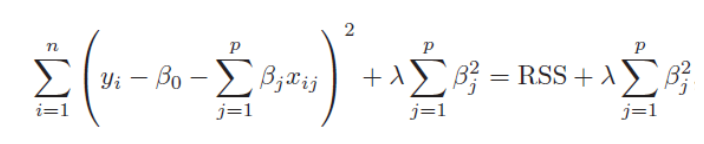

In [5]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이터셋 크기 :',bostonDF.shape)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

Boston 데이터셋 크기 : (506, 14)


In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


※ __"neg_mean_squared_error" 사용 이유__: 사이킷런에서 교차검증은 scoring 매개변수에 낮을수록 좋은 비용함수를 적용하는 것이 아닌, 클수록 좋은 호용 함수를 기대하기 때문에, -MSE인 'neg_mean_squared_error' 함수를 사용

In [8]:
# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0 , 0.1 , 1 , 10 , 100]

# alphas list 값을 iteration하면서 alpha에 따른 평균 rmse 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    
    #cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


alpha=100일 때, 평균 RMSE값이 가장 낮음

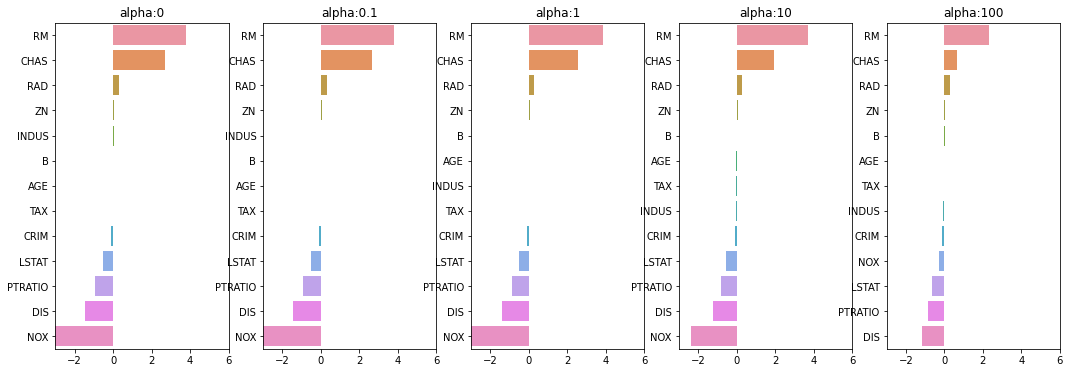

In [9]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성  
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

alpha가 증가될수록 NOX, RM 등의 피처의 회귀 계수가 작아짐

In [10]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


## 라쏘 회귀 (L1 규제 적용)

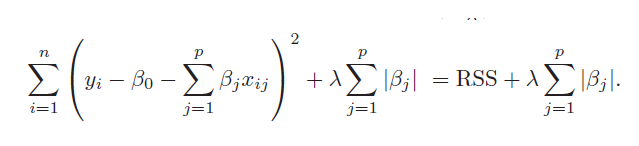

In [15]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, 
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        
        model.fit(X_data_n , y_target_n)
        if return_coeff:
            coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff
    
    return coeff_df

In [12]:
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


In [13]:
print(lasso_alphas)

[0.07, 0.1, 0.5, 1, 3]


In [14]:
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


alpha값이 증가하면 회귀 계수가 작아지다 0으로 바뀜

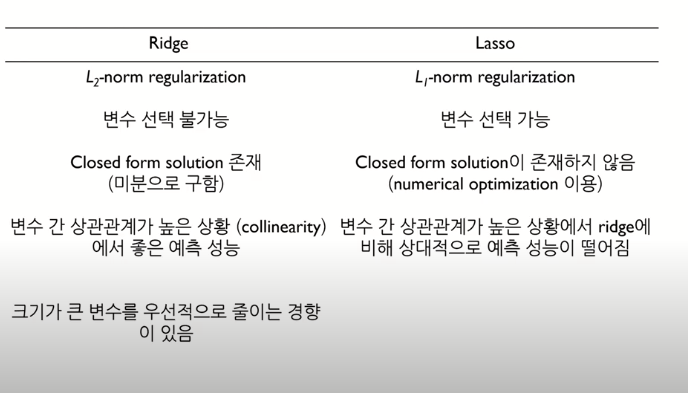

## 엘라스틱넷 회귀 (L1규제 + L2규제 적용)

In [17]:
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [18]:
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


라쏘보다는 상대적으로 회귀계수가 0이되는 피처가 적음

## 선형 회귀 모델을 위한 데이터 변환

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [21]:
import warnings
warnings.filterwarnings("ignore")

scale_methods=[(None, None), ('Standard', None), ('Standard', 2), 
               ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], 
                                    input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, 
                        y_target_n=y_target, verbose=False, return_coeff=False)

(506, 13) (506, 13)

## 변환 유형:None, Polynomial Degree:None
alpha 0일 때 5 폴드 세트의 평균 RMSE: 5.829 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 
(506, 13) (506, 13)

## 변환 유형:Standard, Polynomial Degree:None
alpha 0일 때 5 폴드 세트의 평균 RMSE: 5.829 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 
(506, 104) (506, 13)

## 변환 유형:Standard, Polynomial Degree:2
alpha 0일 때 5 폴드 세트의 평균 RMSE: 193717032281340.750 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 
(506, 13) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0일 때 5 폴드 세트의 평균 RMSE: 5.829 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 
(5

# 로지스틱 회귀

- 선형 회귀 방식을 __분류__에 적용 (y가 연속분포가 아닌 이원분포를 따름)
- 독립변수는 선형이 아니지만, 가중치 변수가 선형이므로 선형 회귀 계열

__<로지스틱 회귀식>__
- Y의 범위가 [0,1]이 되도록 선형 회귀에 로짓 변환을 함.
- $p = P(y=1|x)$(x가 주어졌을 때, 양성 클래스로 예측할 확률)일 때, 로지스틱 회귀 공식: 
$log\frac{p}{1-p} = \beta X => \frac{p}{1-p} = e^{\beta X} => p=\frac{e^{\beta X}}{1+e^{\beta X}} => p = \frac{1}{1+e^{-\beta X}} $

## [실습] 위스콘신 유방암 데이터

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train , X_test, y_train , y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test , lr_preds)))

accuracy: 0.977
roc_auc: 0.972


**하이퍼파라미터 튜닝**
- penalty: l2 or l1
- C(= 1/alpha): C값이 작을수록 규제 강도 큼

In [25]:
from sklearn.model_selection import GridSearchCV

params={'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, 
                                                  grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


# 회귀 트리

회귀 함수를 기반으로 하지 않고 트리를 기반으로 하는 회귀 방식
- 리프 노드에서 예측 결정 값을 만들 때, 회귀 트리는 리프 노드에 속한 데이터의 y값의 평균을 구해 회귀 예측 결정 값 계산
- 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 모두 회귀 가능 (CART 기반 회귀)
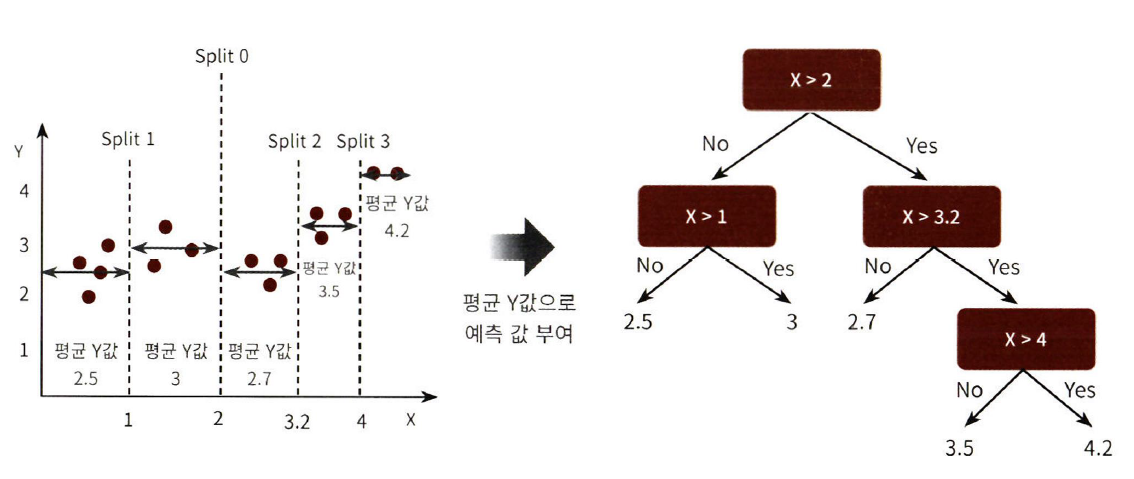

## [실습] 보스턴 주택 가격 예측

### RandomForestRegressor 학습

In [34]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# 보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1,inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


### 여러 회귀 트리를 이용한 학습

In [37]:
def get_model_cv_prediction(model, X_data, y_target):
    import warnings
    warnings.filterwarnings("ignore")

    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
[11:39:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.089 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


성능: XGBRegressor > GradientBoostingRegressor > RandomForestRegressor > LGBMRegressor > DecisionTreeRegressor

<AxesSubplot:>

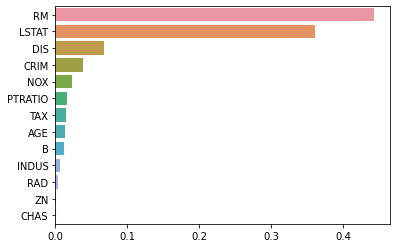

In [29]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

### 선형 회귀 vs. 회귀 트리

#### 데이터 분포 시각화

(100, 2)


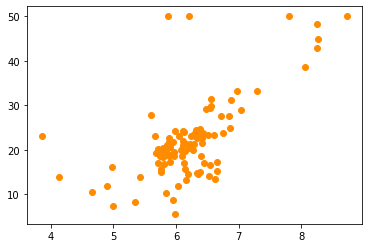

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

bostonDF_sample = bostonDF[['RM','PRICE']] #가장 중요도 높은 변수 RM만 사용
bostonDF_sample = bostonDF_sample.sample(n=100,random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM , bostonDF_sample.PRICE,c="darkorange")

#### Linear Regression vs. DecisionTreeRegression 시각화

In [31]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 데이터 셋 생성. 
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행. 
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

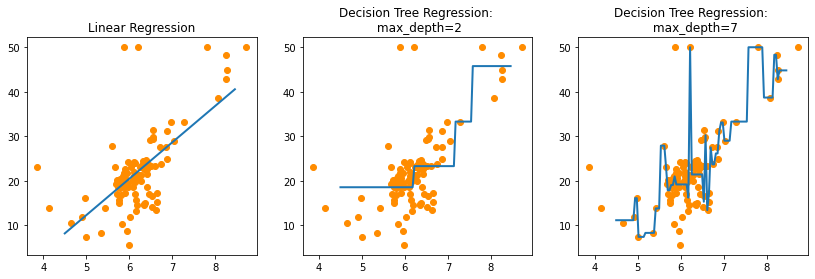

In [32]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

- 선형 회귀: 직선으로 예측 회귀선 표현
- 회귀 트리: 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선 표현
    - max_depth=7로 커지면 학습 데이터의 이상치도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 되기 쉬운 모델 생성